In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer

In [2]:
clinical_attributes = pd.read_csv('step_01/clinical_attributes.csv')
mutation = pd.read_csv('step_01/mutation.csv')
z_score = pd.read_csv('step_01/z_score.csv')
response = pd.read_csv('step_01/response.csv')

# Limpieza de nulos

### Cuantos valores nulos tengo por columna

In [3]:
nulls = clinical_attributes.isnull().sum()
nulls[nulls > 0].sort_values(ascending=False)

tumor_stage                       501
3-gene_classifier_subtype         204
primary_tumor_laterality          106
neoplasm_histologic_grade          72
cellularity                        54
mutation_count                     45
er_status_measured_by_ihc          30
type_of_breast_surgery             22
tumor_size                         20
cancer_type_detailed               15
tumor_other_histologic_subtype     15
oncotree_code                      15
dtype: int64

In [4]:
nulls = mutation.isnull().sum()
nulls[nulls > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [5]:
nulls = z_score.isnull().sum()
nulls[nulls > 0].sort_values(ascending=False)

Series([], dtype: int64)

## Valores nulos en clinical attributes
El la unica seccion con valores nulos es clinical attributes, se realiza un analisis de estos

En este caso es super dificil llenar los valores con la 

In [6]:
# Contando la cantidad de nulos por columna
null_columns = clinical_attributes.isnull().sum()
null_columns = null_columns[null_columns > 0]
null_columns

type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
tumor_other_histologic_subtype     15
primary_tumor_laterality          106
mutation_count                     45
oncotree_code                      15
3-gene_classifier_subtype         204
tumor_size                         20
tumor_stage                       501
dtype: int64

### Eliminacion de filas para los nulos menores al 5% del total
En este caso puedo permitirme perder aquellos valores que representen menos del 5%

In [7]:
shape_before = clinical_attributes.shape
null_below_threshold = null_columns[null_columns < 0.05 * clinical_attributes.shape[0]]
tmp_df = pd.DataFrame(null_below_threshold, columns=['Nulos']).reset_index(names=['Columna', 'Nulos'])
tmp_df['Porcentaje'] = (tmp_df['Nulos'] / shape_before[0])*100
tmp_df

,Columna,Nulos,Porcentaje
0,type_of_breast_surgery,22,1.155462
1,cancer_type_detailed,15,0.787815
2,cellularity,54,2.836134
3,er_status_measured_by_ihc,30,1.575630
4,neoplasm_histologic_grade,72,3.781513
5,tumor_other_histologic_subtype,15,0.787815
6,mutation_count,45,2.363445
7,oncotree_code,15,0.787815
8,tumor_size,20,1.050420


In [8]:
# En el peor de los casos este es el porcentaje que se extraería de los datos
tmp_df['Porcentaje'].sum()

np.float64(15.126050420168067)

In [9]:
# Eliminando las columnas con nulos
clinical_attributes = clinical_attributes.dropna(subset=null_below_threshold.index)
clinical_attributes.shape

(1677, 28)

In [10]:
# Este porcentaje esta en el borde pero sigue siendo aceptable
print(f"{(1-(clinical_attributes.shape[0]/shape_before[0]))*100}% de las filas eliminadas")

11.922268907563026% de las filas eliminadas


In [11]:
mutation = mutation.loc[clinical_attributes.index]
z_score = z_score.loc[clinical_attributes.index]
response = response.loc[clinical_attributes.index]

### Tratamiento con aquellos nulos que superan el 5%

In [12]:
null_over_threshold = null_columns[null_columns > 0.05 * clinical_attributes.shape[0]]
null_over_threshold

primary_tumor_laterality     106
3-gene_classifier_subtype    204
tumor_stage                  501
dtype: int64

Alto que encontre por ahi

Studies have shown that tumor laterality can impact patient outcomes, including:

Survival rates: Tumors on one side of the body may have better or worse prognosis compared to those on the other side.
Symptom presentation: Tumor location and laterality can influence the symptoms patients experience, such as language deficits in brain tumors.
Treatment outcomes: Surgical accessibility and lymph node removal may vary depending on tumor laterality, affecting treatment efficacy.
Examples of Tumor Laterality in Specific Cancers

Breast Cancer: Left-sided breast cancer is more common, and some studies suggest better survival rates for left-sided tumors.

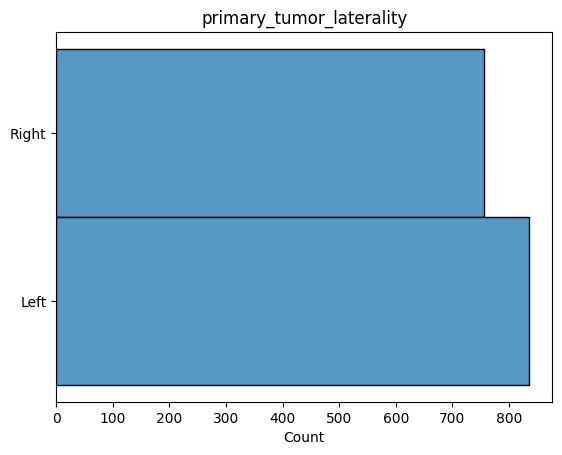

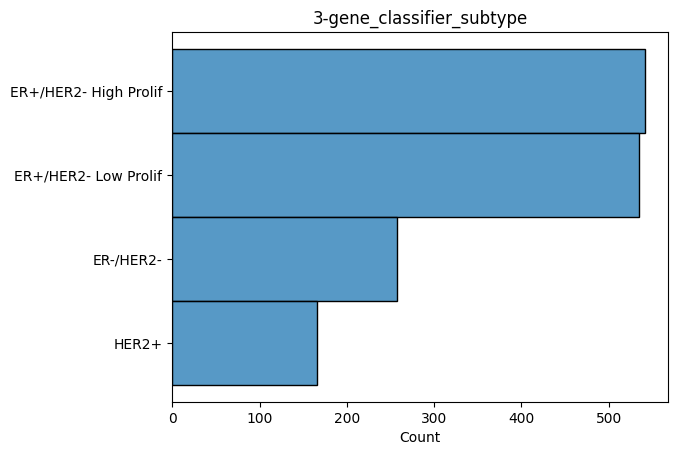

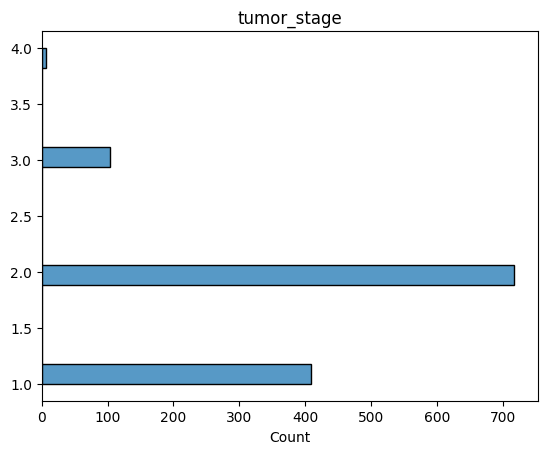

In [13]:
for idx, column in enumerate(null_over_threshold.index):
    sns.histplot(y=clinical_attributes[column].values)
    plt.title(column)
    plt.show()

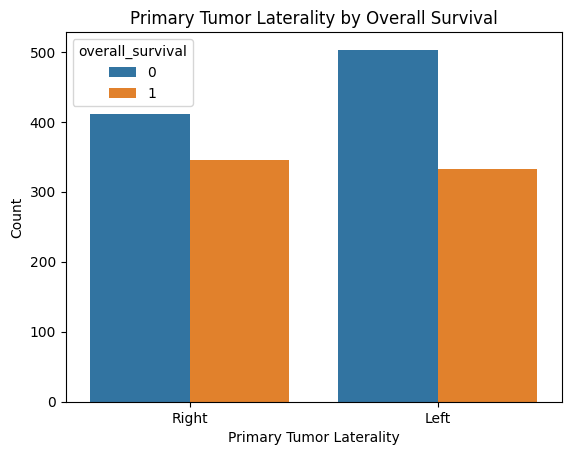

In [15]:
tmp = pd.concat([clinical_attributes, response], axis=1)
sns.countplot(data=tmp, x='primary_tumor_laterality', hue='overall_survival')
plt.title('Primary Tumor Laterality by Overall Survival')
plt.xlabel('Primary Tumor Laterality')
plt.ylabel('Count')
plt.show()

In [16]:
primary_tumor_laterality_counts = clinical_attributes['primary_tumor_laterality'].value_counts()
print(primary_tumor_laterality_counts)

primary_tumor_laterality
Left     835
Right    756
Name: count, dtype: int64


### Llenado de nulos con el mas frecuente
Estos 3 que quedan los podria eliminar pero no puedo porque son importantes para determinar la supervivencia del paciente

In [32]:
# TODO Añadir al pipeline
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(clinical_attributes[null_over_threshold.index])
clinical_attributes[null_over_threshold.index] = imputer.transform(clinical_attributes[null_over_threshold.index])

In [33]:
clinical_attributes.isnull().sum()

patient_id                        0
age_at_diagnosis                  0
type_of_breast_surgery            0
cancer_type                       0
cancer_type_detailed              0
cellularity                       0
chemotherapy                      0
pam50_+_claudin-low_subtype       0
cohort                            0
er_status_measured_by_ihc         0
er_status                         0
neoplasm_histologic_grade         0
her2_status_measured_by_snp6      0
her2_status                       0
tumor_other_histologic_subtype    0
hormone_therapy                   0
inferred_menopausal_state         0
integrative_cluster               0
primary_tumor_laterality          0
lymph_nodes_examined_positive     0
mutation_count                    0
nottingham_prognostic_index       0
oncotree_code                     0
pr_status                         0
radio_therapy                     0
3-gene_classifier_subtype         0
tumor_size                        0
tumor_stage                 

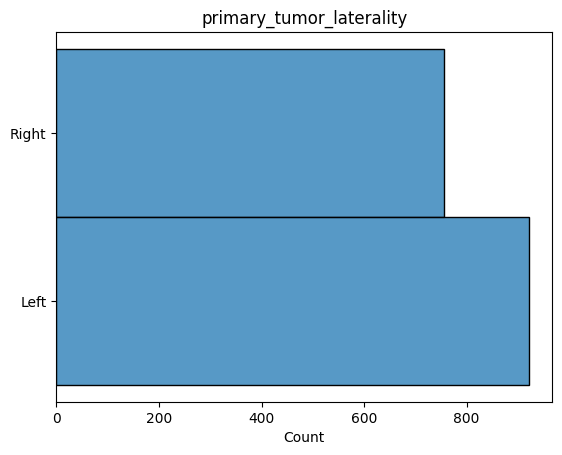

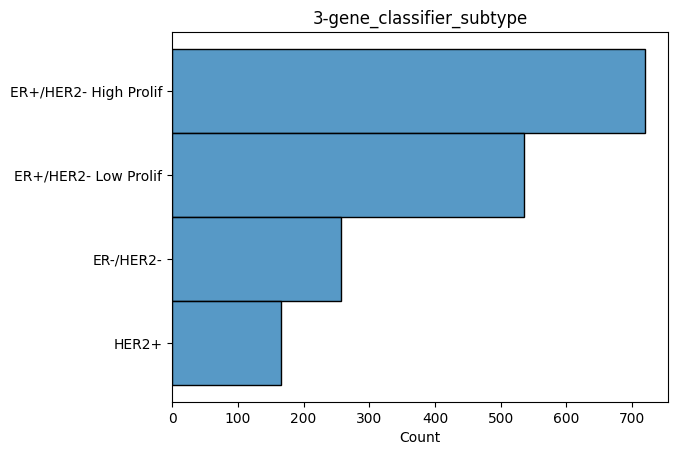

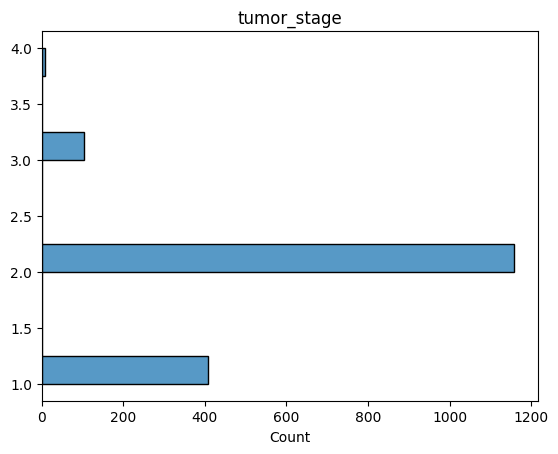

In [34]:
for idx, column in enumerate(null_over_threshold.index):
    sns.histplot(y=clinical_attributes[column].values)
    plt.title(column)
    plt.show()

In [35]:
clinical_attributes.to_csv('step_02/clinical_attributes.csv', index=False)
mutation.to_csv('step_02/mutation.csv', index=False)
z_score.to_csv('step_02/z_score.csv', index=False)
response.to_csv('step_02/response.csv', index=False)